# Optimization via Hybrid ML-Bayesian for Multidimensional Feature Space

In [97]:
import numpy as np
import pandas as pd

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from utils import helper

## Data

C:\Users\MajidMortazavi\AppData\Local\Temp\ipykernel_23420\4180623956.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


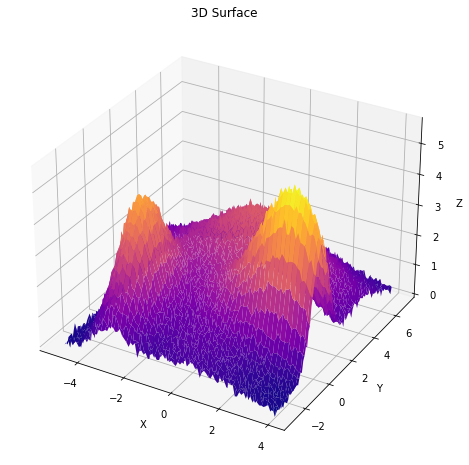

In [173]:
X, Y, Z = helper.generate_3d_data(-5, 4, -3, 7, 100)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface')
plt.show();

In [102]:
df = pd.DataFrame(columns=['X','Y','Z'], dtype=float)

df['X'] = X.reshape(-1, ).astype(float)
df['Y'] = Y.reshape(-1, ).astype(float)
df['Z'] = Z.reshape(-1, ).astype(float)

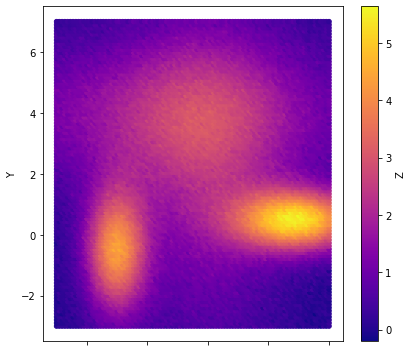

In [103]:
df.plot(kind='scatter', x='X', y='Y', c='Z', cmap='plasma', figsize=(6,5))
plt.tight_layout()
plt.show()

## ML Algorithm

In [104]:
# normalize the input data
x = df[['X', "Y"]].values
y = df['Z'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [105]:
# import RandomForestRegressor from sklearn
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=1000, max_features=2 ,verbose=0) 
model.fit(x_train, y_train)

RandomForestRegressor(max_features=2, n_estimators=1000)

In [106]:
# the coefficient of determination of the prediction.
model.score(x_test, y_test)

0.9859215372755494

In [107]:
tp_indx = np.random.random_integers(0, len(x_test)-1, size=1)
print(f"real value: {y_test[tp_indx]}, model predicted: {model.predict(x_test[tp_indx].reshape(1,-1))}")

real value: [1.87848245], model predicted: [1.67907891]


C:\Users\MajidMortazavi\AppData\Local\Temp\ipykernel_23420\834231924.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 1999 + 1) instead
  tp_indx = np.random.random_integers(0, len(x_test)-1, size=1)


## Bayesian Optimization


As you iterate over and over, the algorithm balances its needs of exploration and exploitation taking into account what it knows about the target function. At each step a Gaussian Process is fitted to the known samples (points previously explored), and the posterior distribution, combined with a exploration strategy (such as UCB (Upper Confidence Bound), or EI (Expected Improvement)), are used to determine the next point that should be explored

We will use the Upper Confidence Bound (UCB) as our utility function. It has the free parameter \(\kappa\) which control the balance between exploration and exploitation; we will set \(\kappa=5\) which, in this case, makes the algorithm quite bold. Additionally we will use the cubic correlation in our Gaussian Process.

Resources: 
- BayesianOptimization Library: https://github.com/fmfn/BayesianOptimization
- Exploitation vs Exploration:
https://github.com/fmfn/BayesianOptimization/blob/master/examples/exploitation_vs_exploration.ipynb
- Visualization: https://philipperemy.github.io/visualization/


In [167]:
def wrapper(X, Y, **kwargs) -> float:
    
    input = np.array([[X, Y]])
    output = model.predict(input, **kwargs)
    output = float(output)

    if (output > -1) & (output < 10):
        return output
    
    else:
        return 10000000

In [169]:
def bo_run(df, wrapper, pbounds, n_iter=10, kappa=5, xi=None, random_state=None):

    df.plot(kind='scatter', x='X', y='Y', c='Z', cmap='plasma', figsize=(6,5))

    bo = BayesianOptimization(wrapper, pbounds, verbose=2)

    bo.maximize(init_points=2, n_iter=n_iter, acq='ucb', kappa=kappa)
    plt.plot(bo.max["params"]["X"],bo.max["params"]["Y"], '*', markersize=10)
    plt.show()
    
    utility = UtilityFunction(kind="ucb", kappa=kappa, xi=0)
    next_point_to_probe = bo.suggest(utility)


    print(f"Next Point to Probe: {next_point_to_probe}")
    print(f"Optimal Point: {bo.max}")

    return bo


pbounds: {'X': (-5.0, 4.0), 'Y': (-3.0, 7.0)}
|   iter    |  target   |     X     |     Y     |
-------------------------------------------------
|  1        |  2.76     |  0.9043   |  3.456    |
|  2        |  2.288    | -1.632    |  4.781    |
|  3        |  2.224    |  1.65     | -0.3393   |
|  4        |  2.576    |  1.845    |  1.596    |
|  5        |  1.952    | -1.87     |  0.4688   |
|  6        |  0.8116   |  4.0      |  4.87     |
|  7        |  0.2735   | -4.925    |  6.923    |
|  8        |  0.006116 | -5.0      | -3.0      |
|  9        |  0.2029   |  4.0      | -3.0      |
|  10       |  0.7711   | -5.0      |  2.376    |
|  11       |  0.9267   |  0.7713   |  7.0      |
|  12       |  0.6034   | -0.6189   | -3.0      |
|  13       |  3.925    |  4.0      |  0.7665   |
|  14       |  2.414    | -1.215    |  2.566    |
|  15       |  0.2125   |  4.0      |  7.0      |
|  16       |  0.8251   | -2.073    |  7.0      |
|  17       | -0.002102 | -5.0      | -0.2541   |
|  1

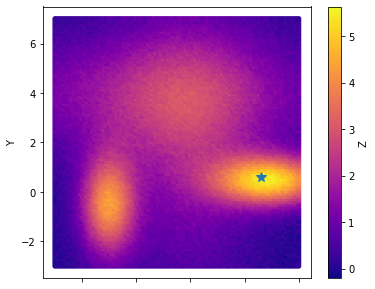

Next Point to Probe: {'X': -3.055401491732396, 'Y': 3.7191880922466414}
Optimal Point: {'target': 5.509923206962713, 'params': {'X': 2.6152990220710652, 'Y': 0.5897015554930367}}


In [170]:
features = ['X', 'Y']
pbounds = {feature: (df[feature].min(), df[feature].max()) for feature in features}
print(f"pbounds: {pbounds}")
# pbounds = {'X': (-5.0, 4.0), 'Y': (-3.0, 7.0)}
bo = bo_run(df, wrapper, pbounds, n_iter=100, kappa=10, xi=None, random_state=None)